In [0]:
import numpy as np
import sklearn
import networkx as nx
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import sys
sys.setrecursionlimit(10**6) 

np.random.seed(42)

# **(X,Y) configuration space:**

In [0]:
def RandomPosition(max_x, max_y):
  xc = np.random.randint(max_x)
  yc = np.random.randint(max_y)
  return [xc,yc]

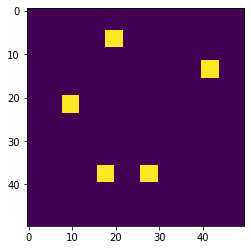

In [0]:
###------ENVIRONMENT-------------
max_x = 50
max_y = 50

c_map = np.zeros((max_x, max_y))
no_obstacles = 5
o_size = 4

obstacles = []
i = 0
while i < no_obstacles:
  ob_pos = RandomPosition(max_x, max_y)
  if ob_pos[0] < o_size/2 and ob_pos[0] > max_x-o_size/2 and ob_pos[1] < o_size/2 and ob_pos[1] > max_y-o_size/2:
    continue
  x1 = int(ob_pos[0]-o_size/2)
  x2 = int(ob_pos[0]+o_size/2)
  y1 = int(ob_pos[1]-o_size/2)
  y2 = int(ob_pos[1]+o_size/2)
  #print(x1, x2, y1, y2, ob_pos)
  c_map[x1:x2, y1:y2] = np.ones((o_size, o_size))
  obstacles.append(ob_pos)
  i += 1

Qstart = [0,0]
Qgoal = [25, 6]
step_size = 3

plt.imshow(c_map, interpolation='nearest')
plt.show()

In [0]:
class Node():
  def __init__(self, idx, Q, dictionary, G):
    self.idx = idx
    self.xpos = Q[0]
    self.ypos = Q[1]
    self.neighbors = []
    self.parent = None
    dictionary[idx] = (Q[0], Q[1])
    G.add_node(idx)

In [0]:
class Tree():
  def __init__(self, curr_iter, curr_node):
    self.root = curr_node

  def find_dist(self, q0, q1):
    xval = q0.xpos-q1[0]
    yval = q0.ypos-q1[1]
    dist_val = np.sqrt(np.square(xval)+np.square(yval))
    return dist_val

  def iterate(self, q, qc, visited):
    if q.neighbors == []:
      return 10000, q
    
    #print('checking',[q.xpos, q.ypos],'for',qc)
    m1 = 1000000
    e1 = None

    for i in range(len(q.neighbors)):
      new_dist = self.find_dist(q.neighbors[i], qc)

      if new_dist < m1:
        e1 = q.neighbors[i]
        m1 = new_dist

      #explore neighbor 
      if q.neighbors[i] not in visited:
        m2, e2 = self.iterate(q.neighbors[i], qc, visited)
        visited.append(q.neighbors[i])

      if m2 < m1:
        m1 = m2 
        e1 = e2

    return m1, e1

  def steer(self, Q_curr, Q_new, step_size):
    q1 = np.asarray(Q_curr)
    q2 = np.asarray(Q_new)

    if q1[0] == q2[0] and q1[1] == q2[1]:
      return q2

    qsub = np.subtract(q2,q1)
    q_dir = qsub/np.linalg.norm(qsub)

    q_change = q_dir * step_size

    q_new = q_change + q1

    q_steer = [round(q_new[0]), round(q_new[1])]
    #print(q1, q_change, q_new, q_steer)

    return q_steer

  def link(self, q1, q2, G):
    if q2 not in q1.neighbors:
      q1.neighbors.append(q2)
      q2.parent = q1
      G.add_edge(q1.idx, q2.idx)
    return

  def find_closest(self, Q_curr):
    min_dist, explore = self.iterate(self.root, Q_curr, [])
    return explore

# **RRT**

In [0]:
num_iters = 1000

step_size = 3
curr_iter = 1
dictionary = {}

G = nx.Graph()
root = Node(0, Qstart, dictionary, G)
graph = Tree(0, root)

till_now = [Qstart]
curr_node = root

while curr_iter < num_iters:
  pos = RandomPosition(max_x, max_y)
  #print('NEW ITERATION')
  
  if c_map[pos[0], pos[1]] == 1: #colliding with obstacle
    #print('COLLISION')
    continue

  nearest_node =graph.find_closest(pos)
  c2 = [nearest_node.xpos, nearest_node.ypos]

  steer_node = graph.steer(c2, pos, step_size)

  add_node = Node(curr_iter, steer_node, dictionary, G)
  graph.link(nearest_node, add_node, G)
  #print('connection between', nearest_node.idx, add_node.idx)
  #print('moving from', [curr_node.xpos, curr_node.ypos], [add_node.xpos, add_node.ypos])

  curr_node = add_node
  curr_iter += 1

  till_now.append(steer_node)
  add = [add_node.xpos, add_node.ypos]

  #print(add, Qgoal)
  if add == Qgoal:
    print('reached goal', add)
    break


reached goal [25.0, 6.0]


In [0]:
v_path = nx.algorithms.shortest_path(G, root.idx, add_node.idx)
print('Vertices for shortest path:',v_path)

path = []
for p in v_path:
  path.append(dictionary[p])
print('Actual path:',path)

Vertices for shortest path: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 22, 23, 25, 445]
Actual path: [(0, 0), (1.0, 3.0), (3.0, 5.0), (6.0, 7.0), (9.0, 8.0), (9.0, 11.0), (9.0, 14.0), (12.0, 15.0), (15.0, 15.0), (18.0, 14.0), (19.0, 11.0), (21.0, 9.0), (24.0, 8.0), (27.0, 8.0), (25.0, 6.0)]


# **2d Mobile Manipulator**

In [58]:
!pip install gtsam

In [0]:
from mobileManipulator import FourLinkMM
import gtsam
import gtsam.utils.plot as gtsam_plot
from gtsam import Pose2
from utils import *

In [0]:
def RandomQ(Qgoal):
  pi = 3.14

  if np.random.randn() <= 0.15: #15% probability that it returns Qgoal
    print('HIT GOAL')
    return Qgoal

  #Each t[i] ranges from -180 to 180
  t1 = np.random.randn()*360-180
  t2 = np.random.randn()*360-180
  t3 = np.random.randn()*360-180
  t4 = np.random.randn()*360-180
  return [t1,t2,t3,t4]

In [0]:
class Node_manip():
  def __init__(self, idx, Q, dictionary, G):
    self.idx = idx
    self.t1 = Q[0]
    self.t2 = Q[1]
    self.t3 = Q[2]
    self.t4 = Q[3]
    self.neighbors = []
    self.parent = None
    dictionary[idx] = Q
    G.add_node(idx)

In [0]:
class Tree_manip():
  def __init__(self, curr_iter, curr_node):
    self.root = curr_node

  def find_dist(self, q0, q1):
    val1 = q0.t1-q1[0]
    val2 = q0.t2-q1[1]
    val3 = q0.t3-q1[2]
    val4 = q0.t4-q1[3]
    dist_val = np.sqrt(np.square(val1)+np.square(val2)+np.square(val3)+np.square(val4))
    return dist_val

  def iterate(self, q, qc):
    if q.neighbors == []: #no neighbors
      return 10000, q
    
    m1 = 1000000
    e1 = None

    for i in range(len(q.neighbors)):
      new_dist = self.find_dist(q.neighbors[i], qc)

      if new_dist < m1:
        e1 = q.neighbors[i]
        m1 = new_dist

      #explore neighbor 
      m2, e2 = self.iterate(e1, qc)
      if m2 < m1:
        m1 = m2 
        e1 = e2

    return m1, e1

  def steer(self, Q_curr, Q_new, step_size):
    q1 = np.asarray(Q_curr)
    q2 = np.asarray(Q_new) #go in direction of q2
    q_sub = np.subtract(q2,q1)
    q_dir = q_sub/np.linalg.norm(q_sub)
    q_dir *= step_size

    q_new = q1+q_dir
    q_steer = [q_new[0], q_new[1], q_new[2], q_new[3]]
    return q_steer

  def link(self, q1, q2, G):
    if q2 not in q1.neighbors:
      q1.neighbors.append(q2)
      q2.parent = q1
      G.add_edge(q1.idx, q2.idx)
    return

  def find_closest(self, Q_curr):
    min_dist, explore = self.iterate(self.root, Q_curr)
    return explore

In [0]:
arm = FourLinkMM()
obstacles = [] #[Polygon([(-10,6), (-1,-1), (-3,6)])]

In [87]:
num_iters = 1000
step_size = 3

dictionary = {}
Qstart = [0,0,0,0]
Qgoal = [0,25,30,12]
curr_iter = 1
G = nx.Graph()
lim = 15 #The robot can stop at a configuration (q1,q2,q3,q4) where q[i] is at most 15 degrees away from Qgoal[i]

root = Node_manip(0, Qstart, dictionary, G)
graph = Tree_manip(0, root)

till_now = [Qstart]
curr_node = root

while curr_iter < num_iters:
  pos = RandomQ(Qgoal)
  #print('NEW ITERATION')
  
  q = np.radians(vector4(pos[0], pos[1], pos[2], pos[3]))
  c0 = [curr_node.t1, curr_node.t2, curr_node.t3, curr_node.t4]

  sTt_ee = arm.fwd_kinematics(q)
  sTt_b, qdash = arm.ik2(sTt_ee)

  if arm.check_collision_with_obstacles(obstacles, sTt_b, c0) == True: #colliding with obstacle
    print('collide')
    continue

  nearest_node =graph.find_closest(pos)
  c1 = [nearest_node.t1, nearest_node.t2, nearest_node.t3, nearest_node.t4]

  steer_node = graph.steer(c1, pos, step_size)

  add_node = Node_manip(curr_iter, steer_node, dictionary, G)
  graph.link(nearest_node, add_node, G)

  curr_node = add_node
  curr_iter += 1

  #print(till_now)
  till_now.append(steer_node)
  add = [add_node.t1, add_node.t2, add_node.t3, add_node.t4]
  #print('add',add,Qgoal)
  if abs(add[0] -Qgoal[0]) <= lim and abs(add[1]-Qgoal[1]) <= lim and abs(add[2]-Qgoal[2]) <= lim and abs(add[3]-Qgoal[3]) <= lim:
    print('reached goal')
    break

FINAL ERROR: 9.808466315874947e-06
add [0.2597792836302929, -1.181370819022783, -2.618843203673957, -0.8237341721263575] [0, 25, 30, 12]
HIT GOAL
FINAL ERROR: 9.611605031818378e-06
add [0.24196541079041775, 0.613967146445775, -0.38206774993521675, 0.05562913460955343] [0, 25, 30, 12]
HIT GOAL
FINAL ERROR: 9.611605031818378e-06
add [0.2241515379505426, 2.4093051119143327, 1.8547077038035238, 0.9349924413454643] [0, 25, 30, 12]
HIT GOAL
FINAL ERROR: 9.611605031818378e-06
add [0.20633766511066745, 4.20464307738289, 4.091483157542264, 1.8143557480813752] [0, 25, 30, 12]
HIT GOAL
FINAL ERROR: 9.611605031818378e-06
add [0.1885237922707923, 5.999981042851448, 6.3282586112810035, 2.693719054817286] [0, 25, 30, 12]
FINAL ERROR: 9.758370065745573e-06
add [1.8350827107024266, -3.4947373454904733, -3.697311680411463, -0.7632348204183965] [0, 25, 30, 12]
HIT GOAL
FINAL ERROR: 9.611605031818378e-06
add [0.17070991943091718, 7.795319008320005, 8.565034065019745, 3.573082361553197] [0, 25, 30, 12]
FIN

In [88]:
v_path = nx.algorithms.shortest_path(G, root.idx, add_node.idx)
print('Vertices for shortest path:',v_path)

path = []
for p in v_path:
  path.append(dictionary[p])
print('Actual path:',path)

Vertices for shortest path: [0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 14]
Actual path: [[0, 0, 0, 0], [0.2597792836302929, -1.181370819022783, -2.618843203673957, -0.8237341721263575], [0.24196541079041775, 0.613967146445775, -0.38206774993521675, 0.05562913460955343], [0.2241515379505426, 2.4093051119143327, 1.8547077038035238, 0.9349924413454643], [0.20633766511066745, 4.20464307738289, 4.091483157542264, 1.8143557480813752], [0.1885237922707923, 5.999981042851448, 6.3282586112810035, 2.693719054817286], [0.17070991943091718, 7.795319008320005, 8.565034065019745, 3.573082361553197], [0.15289604659104203, 9.590656973788564, 10.801809518758485, 4.452445668289108], [-2.093693576550533, 11.179214954464323, 10.91604509129381, 5.642516607851735], [-1.8372722181225316, 12.871890767013978, 13.253318174937462, 6.421137961929701], [-1.58085085969453, 14.564566579563634, 15.590591258581112, 7.199759316007668]]
